In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


Using TensorFlow backend.
/Users/nikoladimic/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nikoladimic/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nikoladimic/opt/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

In [31]:
# Input test and train data

trainFolder = "../input/asl-alphabet/asl_alphabet_train/"
testFolder =  "../input/asl-alphabet/asl_alphabet_test/"

# Converst letter to number
def letterToNumber(letter):
    if(len(letter) == 1):
        letterNum = ord(letter.lower()) - 97
    elif(letter == 'del'):
        letterNum = 26
    elif(letter == 'nothing'):
        letterNum = 27
    elif(letter == 'space'):
        letterNum = 28
    else:
        letterNum = 29
    return letterNum
    
# Normalizes the image file and resizes it
def processImageFile(imageFile):
    # When the picture is downsized - anti_aliasing is suggested
    resizedImage = resize(imageFile, (50, 50, 3), anti_aliasing=True)
    return np.asarray(resizedImage)

# Extracts the data
def extractData(file, color = 1):
    X = []
    y = []
    for folderName in os.listdir(file):
        classLetter = folderName
        classNum = letterToNumber(classLetter)
        fullFolderName = file+folderName
        listOfImages = os.listdir(fullFolderName)
        for imageName in tqdm(listOfImages):
            fullImageName = fullFolderName + "/" + imageName
            imageFile = cv2.imread(fullImageName, color)
            resizedImage = processImageFile(imageFile)            
            X.append(resizedImage)
            y.append(classNum)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [32]:
# Extract the data
X, y = extractData(trainFolder)

100%|██████████| 3000/3000 [00:27<00:00, 108.19it/s]


In [34]:
np.save("../data/XData", X)
print("XData saved")
np.save("../data/yData", y)
print("yData saved")

XData saved
yData saved


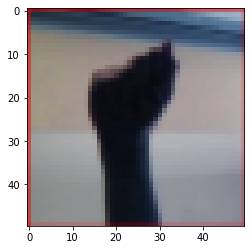

In [40]:
testImage = cv2.imread("../input/asl-alphabet/asl_alphabet_train/A/A1.jpg")
resizedTestImage = processImageFile(t1)
plt.imshow(resizedTestImage, cmap='gray')
plt.show()

In [43]:
X = np.load('../data/XData.npy')
y = np.load('../data/yData.npy')

In [45]:
print(X.shape)
print(y.shape)

(87000, 50, 50, 3)
(87000,)
[17 17 17 ... 22 22 22]


In [46]:
# One hot coding of target variable

numOfClasses = 30
y = to_categorical(y, numOfClasses)

In [48]:
# Splitting data into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [49]:
np.save("../data/Xtrain", X_train)
np.save("../data/Xtest", X_test)
print("X saved")
np.save("../data/Ytrain", y_train)
np.save("../data/Ytest", y_test)
print("Y saved")

X saved
Y saved


In [3]:
X_train = np.load("../data/Xtrain.npy")
X_test = np.load("../data/Xtest.npy")
print("X loaded")
y_train = np.load("../data/Ytrain.npy")
y_test = np.load("../data/Ytest.npy")
print("Y loaded")

X loaded
Y loaded


In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(58290, 50, 50, 3)
(28710, 50, 50, 3)
(58290, 30)
(28710, 30)
